In [ ]:
# Experimental --> Need to rigourously try this out

In [1]:
%matplotlib inline
from keras.models import Sequential,Model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import random
import os
import sys
import cv2
from keras.utils import to_categorical
import matplotlib
from keras.applications import *
from sklearn.model_selection import StratifiedShuffleSplit
from keras import optimizers

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def classes_to_int(label):
    # label = classes.index(dir)
    label = label.strip()
    if label == "Black-grass":  return 0
    if label == "Charlock":  return 1
    if label == "Cleavers":  return 2
    if label == "Common Chickweed":  return 3
    if label == "Common wheat":  return 4
    if label == "Fat Hen":  return 5
    if label == "Loose Silky-bent": return 6
    if label == "Maize":  return 7
    if label == "Scentless Mayweed": return 8
    if label == "Shepherds Purse": return 9
    if label == "Small-flowered Cranesbill": return 10
    if label == "Sugar beet": return 11
    print("Invalid Label", label)
    return 12

NUM_CLASSES = 12
# we need images of same size so we convert them into the size
WIDTH = 256
HEIGHT = 256
DEPTH = 3
dim = 256
inputShape = (WIDTH, HEIGHT, DEPTH)

batch_size = 32


# Functions for plant segmentation
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [3]:
trainDir = '/input/plant_seedlings_classification/train'

In [4]:
def readTrainData(trainDir):
    data = []
    labels = []
    # loop over the input images
    dirs = os.listdir(trainDir) 
    for dir in dirs:
        absDirPath = os.path.join(os.path.sep,trainDir, dir)
        images = os.listdir(absDirPath)
        for imageFileName in images:
            # load the image, pre-process it, and store it in the data list
            imageFullPath = os.path.join(trainDir, dir, imageFileName)
            #print(imageFullPath)
            #img = load_img(imageFullPath)
            ### Following two lines have been changed
            img = cv2.imread(imageFullPath, cv2.IMREAD_COLOR)
            img = segment_plant(img)
            ########################
            
            arr = img_to_array(img)  # Numpy array with shape (233,233,3)
            arr = cv2.resize(arr, (HEIGHT,WIDTH)) #Numpy array with shape (HEIGHT, WIDTH,3)
            #print(arr.shape) 
            data.append(arr)
            label = classes_to_int(dir)
            labels.append(label)
    return data, labels

In [5]:
random.seed(10)
allLabels =  os.listdir(trainDir)  # list of subdirectories and files

print("Loading images...")
X, Y = readTrainData(trainDir)

# scale the raw pixel intensities to the range [0, 1]
X = np.array(X, dtype="float") / 255.0
Y = np.array(Y)
# convert the labels from integers to vectors
Y =  to_categorical(Y, num_classes=12)

x_train  =X
y_train = Y

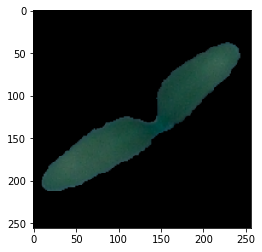

In [35]:
import matplotlib.pyplot as plt 
imgplot = plt.imshow(X[3])

In [10]:
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.01, random_state=42)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.16, random_state=42) # Want a balanced split for all the classes
for train_index, test_index in sss.split(x_train, y_train):
    print("Using {} for training and {} for validation".format(len(train_index), len(test_index)))
    x_train, x_valid = x_train[train_index], x_train[test_index]
    y_train, y_valid = y_train[train_index], y_train[test_index]

Using 3990 for training and 760 for validation


In [11]:
datagen = ImageDataGenerator( horizontal_flip=True, 
                              vertical_flip=True,
                            rescale = 1./255)
                                      
weights = os.path.join('', '/output/weights.h5')

epochs = 100
learning_rate = 0.001
batch_size = 32

callbacks = [ EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
              ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)]

base_model = Xception(input_shape=(dim, dim, 3), include_top=False, weights='imagenet', pooling='avg') # Average pooling reduces output dimensions
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

In [ ]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train)/batch_size, 
                    validation_data=datagen.flow(x_valid, y_valid, batch_size=batch_size), 
                    validation_steps=len(x_valid)/batch_size,
                    callbacks=callbacks,
                    epochs=21, 
                    verbose=1)

In [12]:
# fine tune 

for layer in base_model.layers[:126]:
    layer.trainable  = False
for layer in base_model.layers[126:]:
    layer.trainable = True

weights = os.path.join('', '/output/finetune_weights.h5')


callbacks = [ EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
              ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])


model.load_weights(weights)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train)/batch_size, 
                    validation_data=datagen.flow(x_valid, y_valid, batch_size=batch_size), 
                    validation_steps=len(x_valid)/batch_size,
                    callbacks=callbacks,
                    epochs=21, 
                    verbose=1)

In [15]:
def readTestData(testDir):
    data = []
    filenames = []
    # loop over the input images
    images = os.listdir(testDir)
    for imageFileName in images:
        # load the image, pre-process it, and store it in the data list
        imageFullPath = os.path.join(testDir, imageFileName)
        #print(imageFullPath)
        #img = load_img(imageFullPath)
        img = cv2.imread(imageFullPath, cv2.IMREAD_COLOR)
        img = segment_plant(img)
        arr = img_to_array(img)  # Numpy array with shape (...,..,3)
        arr = cv2.resize(arr, (HEIGHT,WIDTH)) 
        data.append(arr)
        filenames.append(imageFileName)
    return data, filenames


x_test, filenames = readTestData("/input/plant_seedlings_classification/test")
# scale the raw pixel intensities to the range [0, 1]
x_test= np.array(x_test, dtype="float") / 255.0

label_map = {   "Black-grass"               :0,
                "Charlock"                  :1,
                "Cleavers"                  :2,
                "Common Chickweed"          :3,
                "Common wheat"              :4,
                "Fat Hen"                   :5,
                "Loose Silky-bent"          :6,
                "Maize"                     :7,
                "Scentless Mayweed"         :8,
                "Shepherds Purse"           :9,
                "Small-flowered Cranesbill" :10,
                "Sugar beet"                :11}

model.load_weights(weights)

p_test = model.predict(x_train, verbose = 1)

preds = []
for i in range(len(p_test)):
    pos = np.argmax(p_test[i])
    preds.append(list(label_map.keys())[list(label_map.values()).index(pos)])


In [ ]:
df_test = pd.read_csv('/input/plant_seedlings_classification/sample_submission.csv')
df_test['species'] = preds
df_test.to_csv('/output/submission.csv', index=False)